In [1]:
import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)


def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine="dot")
    names = labels if labels else [f"x{i}" for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=str(coef))
    return d


def str_to_dot(string):
    """
    Converts input string from graphviz library to valid DOT graph format.
    """
    graph = string.strip().replace("\n", ";").replace("\t", "")
    graph = (
        graph[:9] + graph[10:-2] + graph[-1]
    )  # Removing unnecessary characters from string
    return graph

/opt/anaconda3/envs/causalAnalysis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_df = pd.read_csv(
    "/Users/lujun.li/projects/causallm-github/causalllm/resource/output/MT/exp_result_Meta-Llama-3-8B-Instruct_sp_bleu.csv"
)

In [3]:
data_df.dropna(inplace=True)
# data_df = data_df[["Temperature", "model", "elapsed_time", "spbleu", "dataset_name"]]
data_df = data_df[["Temperature", "elapsed_time", "spbleu", "dataset_name", "model"]]
print(data_df.shape)
data_df.head()

(2100, 5)


,Temperature,elapsed_time,spbleu,dataset_name,model
0,0.1,12.326098,18.058731,mlt_Latn,Meta-Llama-3-8B-Instruct
1,0.1,4.851995,30.389781,mlt_Latn,Meta-Llama-3-8B-Instruct
2,0.1,4.128073,15.880640,mlt_Latn,Meta-Llama-3-8B-Instruct
3,0.1,6.979652,35.267504,mlt_Latn,Meta-Llama-3-8B-Instruct
4,0.1,4.830333,14.857277,mlt_Latn,Meta-Llama-3-8B-Instruct


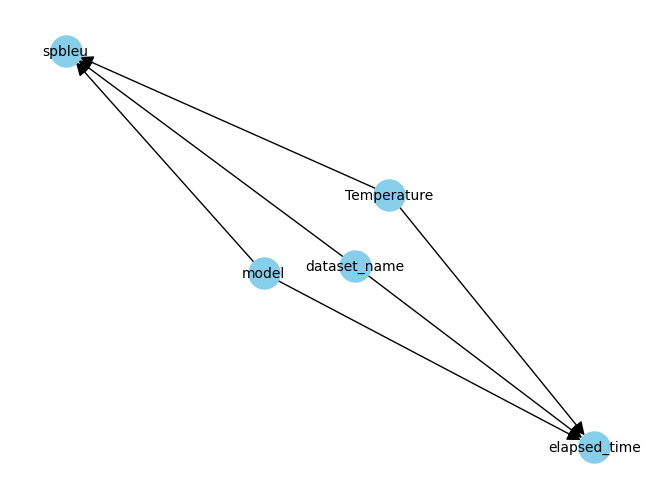

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Add prior knowledge
causal_graph = nx.DiGraph(
    [
        ("Temperature", "elapsed_time"),
        ("Temperature", "spbleu"),
        ("Temperature", "elapsed_time"),
        ("model", "spbleu"),
        ("model", "elapsed_time"),
        ("dataset_name", "elapsed_time"),
        ("dataset_name", "spbleu"),
    ]
)
pos = nx.spring_layout(causal_graph)
nx.draw(
    causal_graph,
    pos,
    with_labels=True,
    node_color="skyblue",
    node_size=500,
    font_size=10,
    arrowsize=20,
)
plt.show()

In [5]:
# from causallearn.search.FCMBased import lingam
# from causallearn.search.FCMBased.lingam.utils import make_dot

# labels = [f"{col}" for i, col in enumerate(data_df.columns)]
# data = data_df.to_numpy()
# model_lingam = lingam.ICALiNGAM()
# model_lingam.fit(data)
# make_dot(model_lingam.adjacency_matrix_, labels=labels)
# # Obtain valid dot format
# graph_dot = make_graph(causal_graph.adjacency(), labels=labels)

In [9]:
# Define Causal Model
from causallearn.search.FCMBased import lingam
from causallearn.search.FCMBased.lingam.utils import make_dot
from dowhy import CausalModel
import dowhy.gcm as gcm

causal_graph = nx.DiGraph(
    [
        ("Temperature", "elapsed_time"),
        ("Temperature", "spbleu"),
        ("Temperature", "elapsed_time"),
        ("model", "spbleu"),
        ("model", "elapsed_time"),
        ("dataset_name", "elapsed_time"),
        ("dataset_name", "spbleu"),
    ]
)

# model = CausalModel(
#     data=data_df,
#     treatment="Temperature",
#     outcome=["spbleu", "elapsed_time"],
#     graph="\n".join(nx.generate_gml(causal_graph)),
#     common_causes=["model", "dataset_name"],
# )

# # Identification
# identified_estimand = model.identify_effect()
# print(identified_estimand)
causal_model = gcm.StructuralCausalModel(causal_graph)
summary_auto_assignment = gcm.auto.assign_causal_mechanisms(causal_model, data_df)
print(summary_auto_assignment)

gcm.fit(causal_model, data_df)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Fitting causal mechanism of node dataset_name: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


In [12]:
data_df_validation = pd.read_csv(
    "/Users/lujun.li/projects/causallm-github/causalllm/resource/output/MT/exp_result_Llama-2-70b-chat-hf_sp_bleu.csv"
)
data_df.dropna(inplace=True)
# data_df = data_df[["Temperature", "model", "elapsed_time", "spbleu", "dataset_name"]]
data_df_validation = data_df_validation[
    ["Temperature", "elapsed_time", "spbleu", "dataset_name", "model"]
]
print(data_df_validation.shape)
data_df_validation.head()

(2100, 5)


,Temperature,elapsed_time,spbleu,dataset_name,model
0,0.1,19.251106,2.692794,mlt_Latn,Llama-2-70b-chat-hf
1,0.1,13.183325,19.193097,mlt_Latn,Llama-2-70b-chat-hf
2,0.1,10.344519,3.268069,mlt_Latn,Llama-2-70b-chat-hf
3,0.1,15.676424,12.334265,mlt_Latn,Llama-2-70b-chat-hf
4,0.1,11.430753,2.051245,mlt_Latn,Llama-2-70b-chat-hf


Test permutations of given graph: 100%|██████████| 50/50 [00:00<00:00, 51.77it/s]


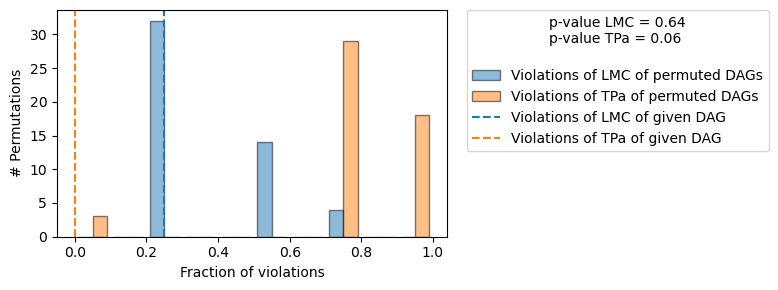

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [13]:
summary_evaluation = gcm.evaluate_causal_model(
    causal_model, data_df_validation, compare_mechanism_baselines=True
)
print(summary_evaluation)

# Echoml for more complicated causal mechanism


As I learnt from the bilibli and some blogs, I found that the dowhy only do basic estimation of causal Model but there are more things more robhust for causal mechanism estimation by using echoml and dowhy. Echoml has forest based non-linear approximaion and causallearn has nn-based analysis.

Let's start with an example and try to understand this framwork

The first thing is to frame the causal model using domain knowledge or causal discovery based on data.

treatement：you

counfounder：这个变量主要是用来找到同时可以对treatement 和outcome都有影响的变量，也叫做 common_causes. 在我们的研究中，其实并没有counfounder， 不属于混淆变量。

Instrument： 这个变量直接影响action， 而且影响outcome的变量一般不直接影响工具变量。这个情况下我们也没有。

比如说 我们研究温度低于accuracy的影响。 【温度，accuracy， model，时长， 模型大小， 语言种类】

在这个情况下，温度，模型大小，语言种类就是aciton or treatement， accuracy就是outcome， model， 模型大小和语言种类就是instrument


Why use ecoml? 因为他可以有更多的自由度，尤其是在causal mechanism的拟合上。


## Let's start to use the ecoml


In [23]:
data_df = pd.read_csv(
    "/Users/lujun.li/projects/causallm-github/causalllm/resource/output/MT/exp_result_Meta-Llama-3-8B-Instruct_sp_bleu.csv"
)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from econml.sklearn_extensions.model_selection import GridSearchCVList
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone
from econml.sklearn_extensions.linear_model import WeightedLasso
from econml.dml import NonParamDML

from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier
# Y is outcomes, X is features, T is treatments
from sklearn.preprocessing import OneHotEncoder

Test on ecoml

In [25]:
# Helper imports
def first_stage_reg():
    return GridSearchCVList(
        [
            Lasso(),
            RandomForestRegressor(n_estimators=100, random_state=123),
            GradientBoostingRegressor(random_state=123),
        ],
        param_grid_list=[
            {"alpha": [0.001, 0.01, 0.1, 1, 10]},
            {"max_depth": [3, None], "min_samples_leaf": [10, 50]},
            {"n_estimators": [50, 100], "max_depth": [3], "min_samples_leaf": [10, 30]},
        ],
        cv=5,
        scoring="neg_mean_squared_error",
    )


def first_stage_clf():
    return GridSearchCVList(
        [
            LogisticRegression(),
            RandomForestClassifier(n_estimators=100, random_state=123),
            GradientBoostingClassifier(random_state=123),
        ],
        param_grid_list=[
            {"C": [0.01, 0.1, 1, 10, 100]},
            {"max_depth": [3, 5], "min_samples_leaf": [10, 50]},
            {"n_estimators": [50, 100], "max_depth": [3], "min_samples_leaf": [10, 30]},
        ],
        cv=5,
        scoring="neg_mean_squared_error",
    )


def final_stage():

    return GridSearchCVList(
        [WeightedLasso(), RandomForestRegressor(n_estimators=100, random_state=123)],
        param_grid_list=[
            {"alpha": [0.001, 0.01, 0.1, 1, 10]},
            {"max_depth": [3, 5], "min_samples_leaf": [10, 50]},
        ],
        cv=5,
        scoring="neg_mean_squared_error",
    )


encoder = OneHotEncoder()
X_categorical = data_df[["dataset_name"]].to_numpy().reshape(-1, 1)
X_encoded = encoder.fit_transform(X_categorical).toarray()
encoded_df = pd.DataFrame(
    X_encoded, columns=encoder.get_feature_names_out(["dataset_name"])
)
data_df_encoded = pd.concat([data_df, encoded_df], axis=1)
Y = data_df[["spbleu"]].to_numpy()
X = data_df_encoded[list(encoded_df.columns)].to_numpy()

Y = data_df[["spbleu"]].to_numpy()
T = data_df[["Temperature"]].to_numpy()

model_y = clone(first_stage_reg().fit(X, Y).best_estimator_)
print(model_y)

model_t = clone(first_stage_reg().fit(X, T).best_estimator_)
print(model_t)

est = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    discrete_treatment=False,
    cv=3,
    n_estimators=4000,
    random_state=123,
)
est.tune(Y, T, X=X).fit(Y, T, X=X, cache_values=True)

est2 = NonParamDML(
    model_y=model_y,
    model_t=model_t,
    cv=3,
    discrete_treatment=False,
    model_final=final_stage(),
)
est2.fit(Y, T, X=X)

Test on data using ecoml and dowhy

In [1]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
from xgboost import XGBRegressor, XGBClassifier

# EconML imports
from econml.dr import LinearDRLearner

# DoWhy imports 
import dowhy
from dowhy import CausalModel

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data_df_MT = pd.read_csv(
    "/Users/lujun.li/projects/causallm-github/causalllm/resource/output/MT/exp_result_Meta-Llama-3-8B-Instruct_sp_bleu.csv"
)
data_df_MT.head()

# Define estimator inputs

# Import the sample multi-attribution data
file_url = "https://msalicedatapublic.z5.web.core.windows.net/datasets/ROI/multi_attribution_sample.csv"
multi_data = pd.read_csv(file_url)
T_bin = multi_data[
    ["Tech Support", "Discount"]
]  # multiple interventions, or treatments
Y = multi_data["Revenue"]  # amount of product purchased, or outcome
X = multi_data[["Size"]]  # heterogeneity feature
W = multi_data.drop(columns=["Tech Support", "Discount", "Revenue", "Size"])  # controls
confounder_names = [
    "Global Flag",
    "Major Flag",
    "SMC Flag",
    "Commercial Flag",
    "IT Spend",
    "Employee Count",
    "PC Count",
]

multi_data.head()

,Global Flag,Major Flag,SMC Flag,Commercial Flag,IT Spend,Employee Count,PC Count,Size,Tech Support,Discount,Revenue
0,1,0,1,0,45537,26,26,152205,0,1,17688.36300
1,0,0,1,1,20842,107,70,159038,0,1,14981.43559
2,0,0,0,1,82171,10,7,264935,1,1,32917.13894
3,0,0,0,0,30288,40,39,77522,1,1,14773.76855
4,0,0,1,0,25930,37,43,91446,1,1,17098.69823


In [3]:
# Define estimator inputs
T_bin = multi_data[
    ["Tech Support", "Discount"]
]  # multiple interventions, or treatments
Y = multi_data["Revenue"]  # amount of product purchased, or outcome
X = multi_data[["Size"]]  # heterogeneity feature
W = multi_data.drop(
    columns=["Tech Support", "Discount", "Revenue", "Size"]
)  # controls W is counfounder
confounder_names = [
    "Global Flag",
    "Major Flag",
    "SMC Flag",
    "Commercial Flag",
    "IT Spend",
    "Employee Count",
    "PC Count",
]

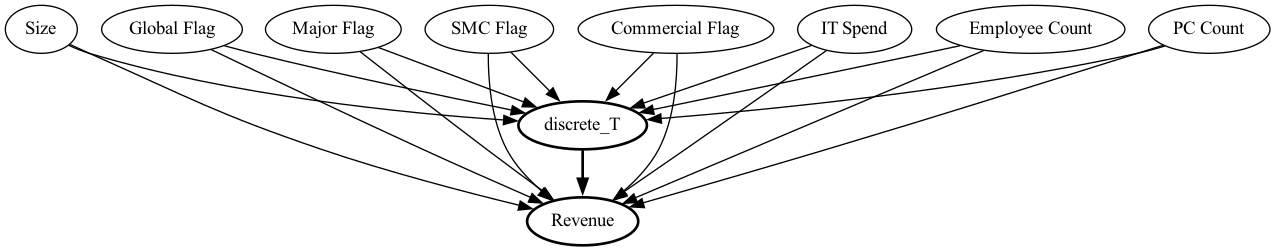

In [4]:
# Transform T to one-dimensional array with consecutive integer encoding # Encode treatement to interger
def treat_map(t):
    return np.dot(t, 2 ** np.arange(t.shape[0]))


T = np.apply_along_axis(treat_map, 1, T_bin).astype(int)
multi_data["discrete_T"] = T

# initiate an EconML cate estimator
est = LinearDRLearner(
    model_regression=XGBRegressor(learning_rate=0.1, max_depth=3),
    model_propensity=XGBClassifier(
        learning_rate=0.1, max_depth=3, objective="multi:softprob"
    ),
    random_state=1,
)

# fit through dowhy
test_customers = X.iloc[:1000].values
est_dw = est.dowhy.fit(
    Y,
    T,
    X=X,
    W=W,
    outcome_names=["Revenue"],
    treatment_names=["discrete_T"],
    feature_names=["Size"],
    confounder_names=confounder_names,
    target_units=test_customers,
)

# Visualize causal graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(Image(to_pydot(est_dw._graph._graph).create_png()))
except:
    # Fall back on default graph view
    est_dw.view_model(layout=None)

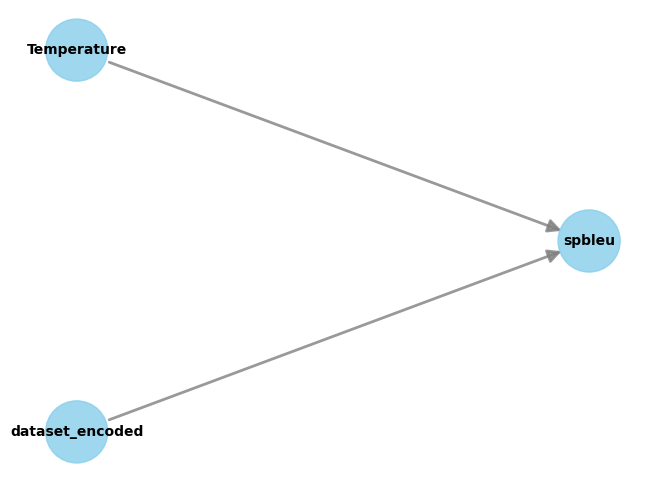

In [5]:
# X feature, Y outcomt, W counfounder, T treatement


def string_encode(data):
    unique_strings = data.unique()
    string_map = {string: i for i, string in enumerate(unique_strings)}
    encoded_data = data.map(string_map)
    return encoded_data


encoded_dataset_name = string_encode(data_df_MT["dataset_name"])
data_df_MT["dataset_encoded"] = encoded_dataset_name

T_data_frame = data_df_MT[["Temperature"]]
Y_data_frame = data_df_MT["spbleu"]
X_data_frame = data_df_MT[["dataset_encoded"]]

est_data_frame = LinearDRLearner(
    model_regression=XGBRegressor(learning_rate=0.1, max_depth=3),
    model_propensity=XGBClassifier(
        learning_rate=0.1, max_depth=3, objective="multi:softprob"
    ),
    random_state=1,
)

#   EcoML defines counfounder and features name seperately
# est_data_frame_tem = est_data_frame.dowhy.fit(
#     Y=Y_data_frame,
#     T=T_data_frame.to_numpy(),
#     X=X_data_frame,
#     outcome_names=["spbleu"],
#     treatment_names=["Temperature"],
#     feature_names=["dataset_encoded"],
# )

# # Visualize causal graph
# try:
#     # Try pretty printing the graph. Requires pydot and pygraphviz
#     display(Image(to_pydot(est_data_frame._graph._graph).create_png()))
# except:
#     # Fall back on default graph view
#     est_dw.view_model(layout=None)

model = CausalModel(
    data=data_df_MT,
    treatment=["Temperature"],
    outcome=["spbleu"],
    effect_modifiers=["dataset_encoded"],
)
model.view_model()

In [6]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                  
──────────────(E[spbleu])
d[Temperature]           
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→spbleu then P(spbleu|Temperature,,U) = P(spbleu|Temperature,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [7]:
linear_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    control_value=1.0,
    treatment_value=2.0,
)
print(linear_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                  
──────────────(E[spbleu])
d[Temperature]           
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→spbleu then P(spbleu|Temperature,,U) = P(spbleu|Temperature,)

## Realized estimand
b: spbleu~Temperature+Temperature*dataset_encoded
Target units: 

## Estimate
Mean value: -5.470102762405488
### Conditional Estimates
__categorical__dataset_encoded
(-0.001, 0.8]    -0.459979
(0.8, 1.6]       -2.965041
(1.6, 2.4]       -5.470103
(2.4, 3.2]       -7.975165
(3.2, 4.0]      -10.480227
dtype: float64


### Plus echoml


double machine learning methods with linear assumption

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

dml_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    control_value=1.0,
    treatment_value=2.0,
    target_units="ate",  # condition used for CATE
    confidence_intervals=False,
    method_params={
        "init_params": {
            "model_y": GradientBoostingRegressor(),
            "model_t": GradientBoostingRegressor(),
            "model_final": LassoCV(fit_intercept=False),
            "featurizer": PolynomialFeatures(degree=1, include_bias=False),
        },
        "fit_params": {},
    },
)
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                  
──────────────(E[spbleu])
d[Temperature]           
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→spbleu then P(spbleu|Temperature,,U) = P(spbleu|Temperature,)

## Realized estimand
b: spbleu~Temperature | dataset_encoded
Target units: ate

## Estimate
Mean value: -5.366978353830225
Effect estimates: [[-9.26680225]
 [-9.26680225]
 [-9.26680225]
 ...
 [-1.46715446]
 [-1.46715446]
 [-1.46715446]]



In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference

dml_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    target_units="ate",
    confidence_intervals=True,
    method_params={
        "init_params": {
            "model_y": GradientBoostingRegressor(),
            "model_t": GradientBoostingRegressor(),
            "model_final": LassoCV(fit_intercept=False),
            "featurizer": PolynomialFeatures(degree=1, include_bias=True),
        },
        "fit_params": {
            "inference": BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
        },
    },
)
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                  
──────────────(E[spbleu])
d[Temperature]           
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→spbleu then P(spbleu|Temperature,,U) = P(spbleu|Temperature,)

## Realized estimand
b: spbleu~Temperature | dataset_encoded
Target units: ate

## Estimate
Mean value: -5.35259402347997
Effect estimates: [[-9.19098932]
 [-9.19098932]
 [-9.19098932]
 ...
 [-1.51419873]
 [-1.51419873]
 [-1.51419873]]
95.0% confidence interval: [[[-9.66861167 -9.66861167 -9.66861167 ... -2.431527   -2.431527
   -2.431527  ]]

 [[-7.52418456 -7.52418456 -7.52418456 ... -1.07824812 -1.07824812
   -1.07824812]]]



Use customized treatements

In [10]:
test_cols = data_df_MT["Temperature"]  # only need effect modifiers' values
test_arr = np.random.uniform(0, 5, len(test_cols))
test_df = pd.DataFrame(np.array(test_arr).transpose())
test_df["dataset_encoded"] = data_df_MT["dataset_encoded"]
dml_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    target_units=test_df,
    confidence_intervals=False,
    method_params={
        "init_params": {
            "model_y": GradientBoostingRegressor(),
            "model_t": GradientBoostingRegressor(),
            "model_final": LassoCV(),
            "featurizer": PolynomialFeatures(degree=1, include_bias=True),
        },
        "fit_params": {},
    },
)
print(dml_estimate.cate_estimates)

[[-8.5492118]
 [-8.5492118]
 [-8.5492118]
 ...
 [-1.8225909]
 [-1.8225909]
 [-1.8225909]]


# Use ECONML methods using causal forests

In [11]:
from sklearn.ensemble import RandomForestRegressor

model_tree = CausalModel(
    data=data_df_MT,
    treatment=["Temperature"],
    outcome=["spbleu"],
    effect_modifiers=["dataset_encoded"],
)
identified_estimand_tree = model_tree.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand_tree)

treelearner_estimate = model_tree.estimate_effect(
    identified_estimand=identified_estimand_tree,
    method_name="backdoor.econml.dml.CausalForestDML",
    confidence_intervals=True,
    method_params={
        "init_params": {
            "model_y": GradientBoostingRegressor(),
            "model_t": GradientBoostingRegressor(),
            "featurizer": PolynomialFeatures(degree=1, include_bias=True),
        },
        "fit_params": {
            "inference": BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
        },
    },
)
print(treelearner_estimate)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                  
──────────────(E[spbleu])
d[Temperature]           
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→spbleu then P(spbleu|Temperature,,U) = P(spbleu|Temperature,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                  
──────────────(E[spbleu])
d[Temperature]           
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→spbleu then P(spbleu|Temperature,,U) = P(spbleu|Temperature,)

## Realized estimand
b: spbleu~Temperature | dataset_encoded
Target units: ate

## Estimate
Mean value: -5.466902480248056
Effect estimates: [[-8.0957889 ]
 [-8.0957889 ]
 [-8.0957889 ]
 

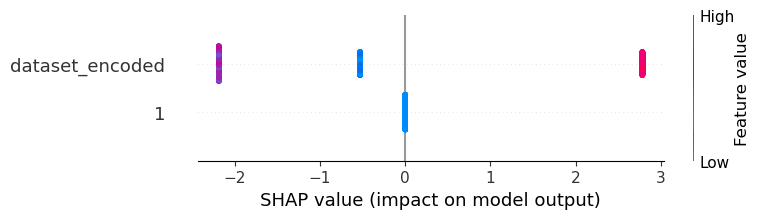

In [36]:
shap_values = treelearner_estimate.params["_estimator_object"].shap_values(
    X=data_df_MT[["Temperature"]],
)

# shap.plots.force(shap_values["spbleu"]["Temperature"])
import shap

shap.summary_plot(shap_values["spbleu"]["Temperature"])

# Refutation

ad-hoc graphe refutation

In [45]:
print(model_tree._graph._graph.nodes())
print(model_tree._graph._graph.edges())

['Temperature', 'spbleu', 'dataset_encoded']
[('Temperature', 'spbleu'), ('dataset_encoded', 'spbleu')]


In [47]:
from dowhy.gcm.falsify import falsify_graph

# data_df_MT = pd.read_csv(
#     "/Users/lujun.li/projects/causallm-github/causalllm/resource/output/MT/exp_result_Meta-Llama-3-8B-Instruct_sp_bleu.csv"
# )
data_df_validation = pd.read_csv(
    "/Users/lujun.li/projects/causallm-github/causalllm/resource/output/MT/exp_result_Llama-2-70b-chat-hf_sp_bleu.csv"
)


def string_encode(data):
    unique_strings = data.unique()
    string_map = {string: i for i, string in enumerate(unique_strings)}
    encoded_data = data.map(string_map)
    return encoded_data


encoded_dataset_name = string_encode(data_df_validation["dataset_name"])
data_df_validation["dataset_encoded"] = encoded_dataset_name

Test permutations of given graph: 100%|██████████| 6/6 [00:03<00:00,  1.77it/s]


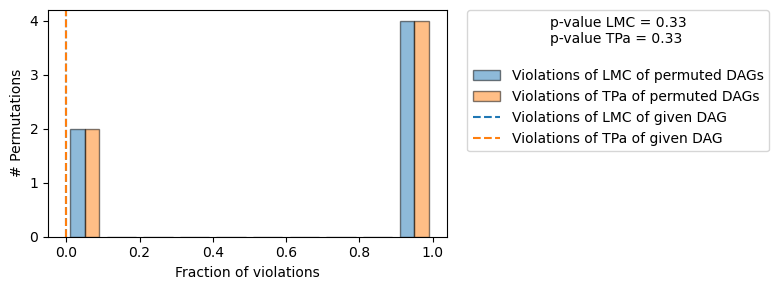

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is not informative because 2 / 6 of the permutations lie in the Markov                  |
| equivalence class of the given DAG (p-value: 0.33).                                                   |
| The given DAG violates 0/2 LMCs and is better than 66.7% of the permuted DAGs (p-value: 0.33).        |
| Based on the provided significance level (0.05) and because the DAG is not informative,               |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
Graph is falsifiable: False, Graph is falsifie

In [59]:
# causal_graph is a networkx digraph
# https://www.pywhy.org/dowhy/v0.11.1/user_guide/modeling_causal_relations/refuting_causal_graph/refute_causal_structure.html
# https://www.pywhy.org/dowhy/v0.11.1/example_notebooks/gcm_falsify_dag.html
result = falsify_graph(
    model_tree._graph._graph,
    data_df_validation,
    show_progress_bar=True,
    plot_histogram=True,
)
print(result)
print(
    f"Graph is falsifiable: {result.falsifiable}, Graph is falsified: {result.falsified}"
)

post-hoc refutation

In [53]:
refuter_list = [
    "bootstrap_refuter",
    "data_subset_refuter",
    "add_unobserved_common_cause",
    "random_common_cause",
]

refuter_list = [
    "random_common_cause",
]

In [55]:
refutation_list = []
for refuter in refuter_list:
    ref = model.refute_estimate(
        identified_estimand_tree,
        treelearner_estimate,
        method_name=refuter,
        show_progress_bar=True,
    )
    refutation_list.append(ref)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x104c1c7c0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/causalAnalysis/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
refuter_count = 1
for refutation in refutation_list:
    print(
        "####### Refutation {}#######################################################################################".format(
            refuter_count
        )
    )
    print("*** Class Name ***")
    print()
    print(refutation.refutation_type)
    print()
    print(refutation)
    print(
        "########################################################################################################"
    )
    print()
    refuter_count += 1